In [70]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests

# Load Excel file
df = pd.read_excel('Field Coordinates.xlsx', sheet_name='Y_2024')

# API config
YOUR_API_KEY = 'xxxxxxxxxxxxxxxxxx'
header = {"Authorization": YOUR_API_KEY}

# List of models to request
# models = ["Ensemble", "SSEBop", "DisALEXI", "PTJPL", "geeSEBAL", "eeMETRIC", "SIMS"]
models = ["Ensemble"]

# Variables to request
# variables = ["ET", "ET_MAD_MIN", "ET_MAD_MAX", "ETo", "ETr", "ETof", "NDVI", "PR"]
variables = ["ET"] 

# Store all records in one list
all_records = []

# Loop over each row in the Excel
for idx, row in df.iterrows():
    id_number = str(row['ID'])
    farm = str(row['Farm'])
    section = str(row['Section'])
    year = int(row['Year'])
    latitude = float(row['Latitude'])
    longitude = float(row['Longitude'])

    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    for variable in variables:
        print(f"\n📍 Processing: ID={id_number} | Var={variable}")

        et_data = {}

        for model in models:
            args = {
                "date_range": [start_date, end_date],
                "interval": "daily",
                "geometry": [longitude, latitude],
                "model": model,
                "variable": variable,
                "reference_et": "gridMET",
                "units": "mm",
                "file_format": "JSON"
            }

            response = requests.post(
                headers=header,
                json=args,
                url="https://openet-api.org/raster/timeseries/point"
            )

            if response.status_code == 200:
                model_data = response.json()
                print(f"✅ {model} - {len(model_data)} records fetched.")
                et_data[model] = model_data
            else:
                print(f"❌ {model} - {response.status_code}: {response.text}")

        # Append full record
        all_records.append({
            "id_number": id_number,
            "farm": farm,
            "section": section,
            "year": year,
            "latitude": latitude,
            "longitude": longitude,
            "variable": variable,
            "et_data": et_data
        })

# Save everything to one JSON file
with open("openet_all_locations_2024.json", "w") as f:
    json.dump(all_records, f, indent=2)

print("\n✅ All data saved to 'openet_all_variables_all_locations.json'")



📍 Processing: ID=1 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=2 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=3 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=4 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=5 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=6 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=7 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=8 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=9 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=10 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=11 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=12 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=13 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=14 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=15 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=16 | Var=ET
✅ Ensemble - 366 re

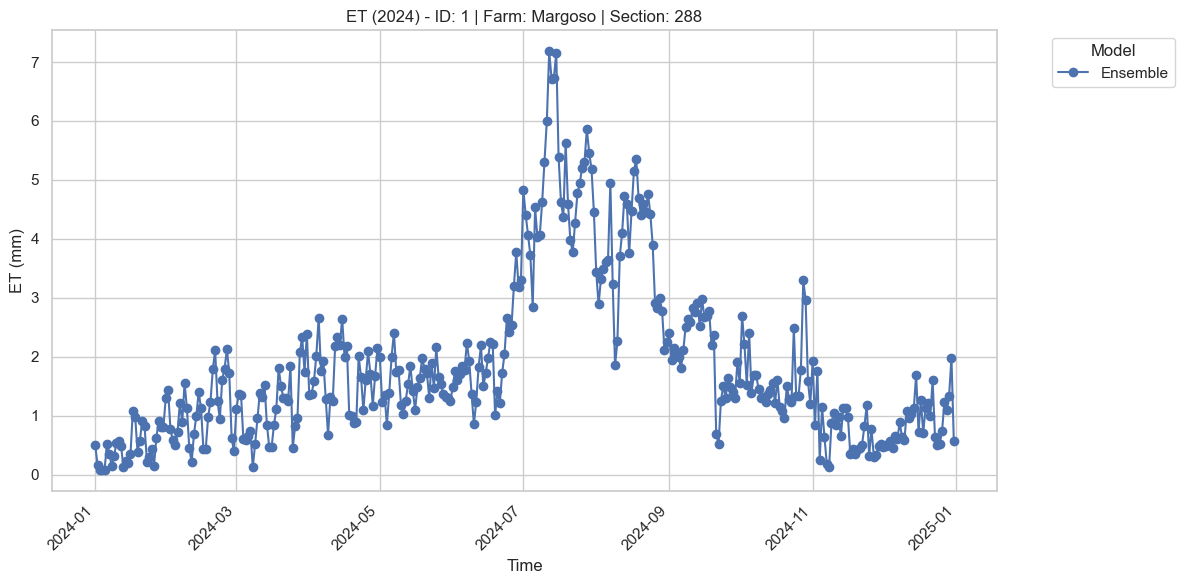

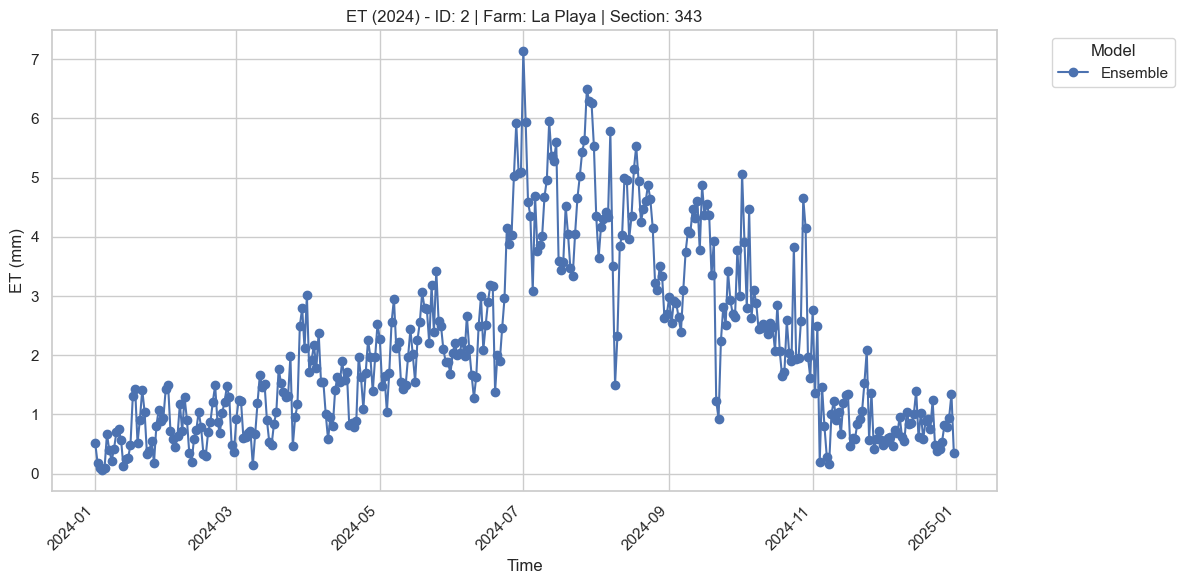

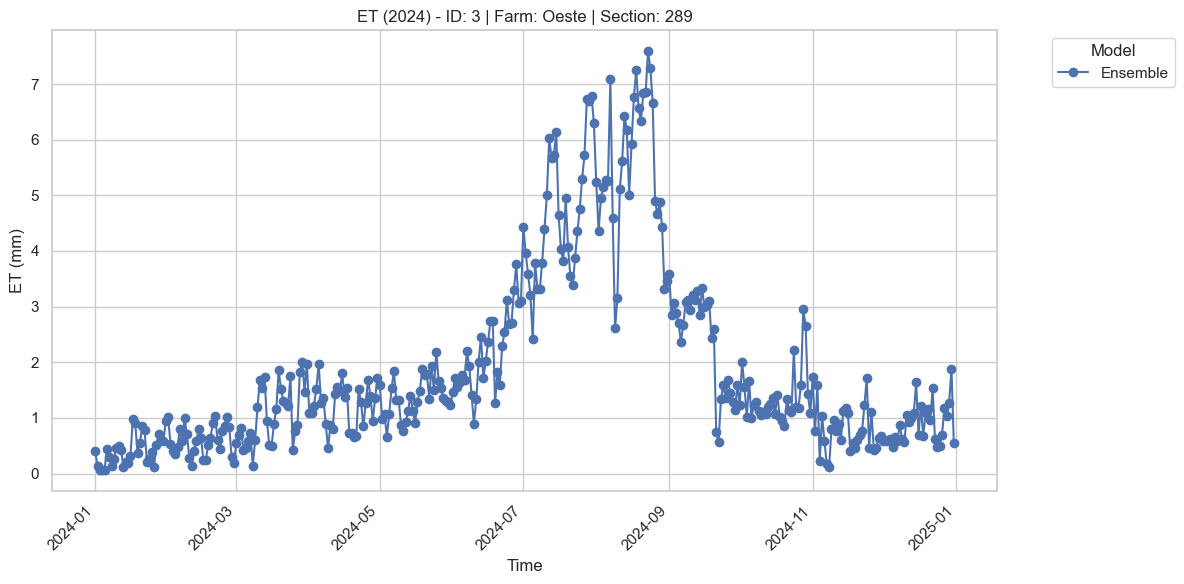

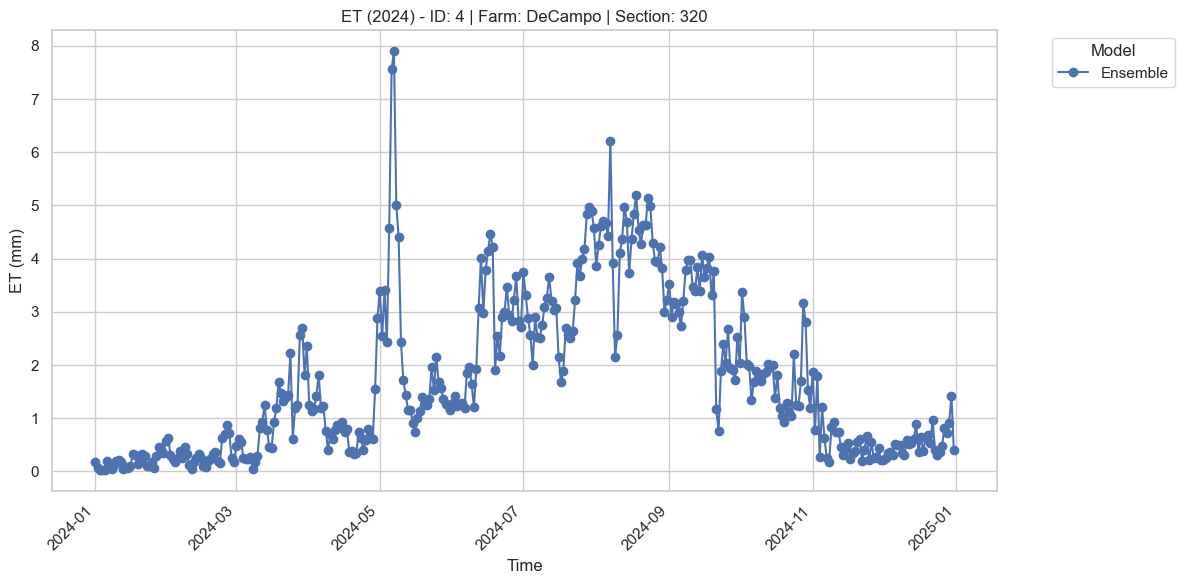

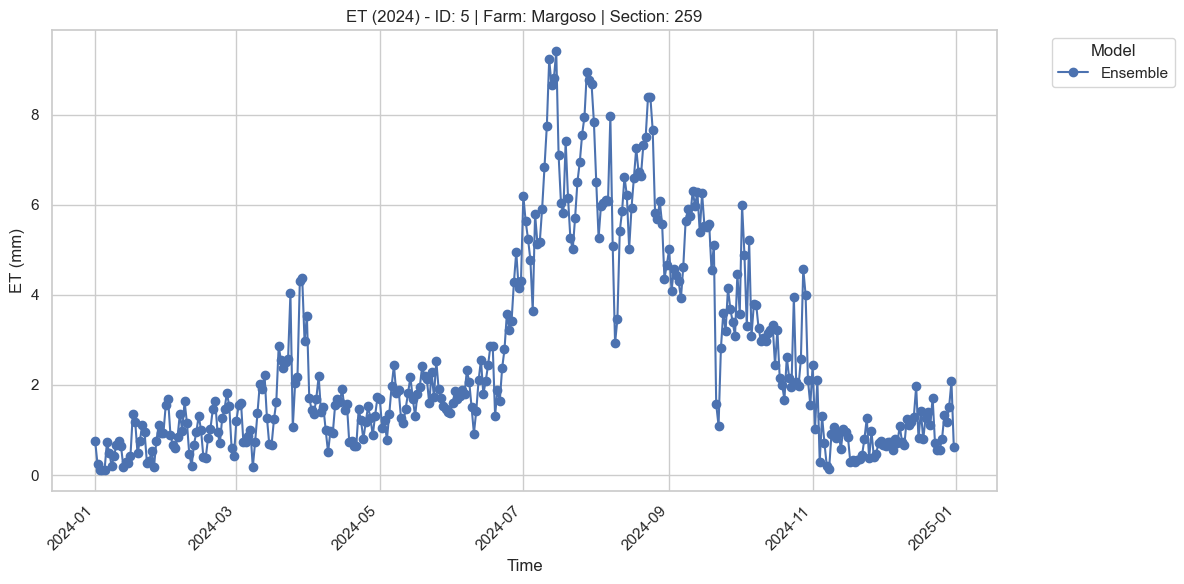

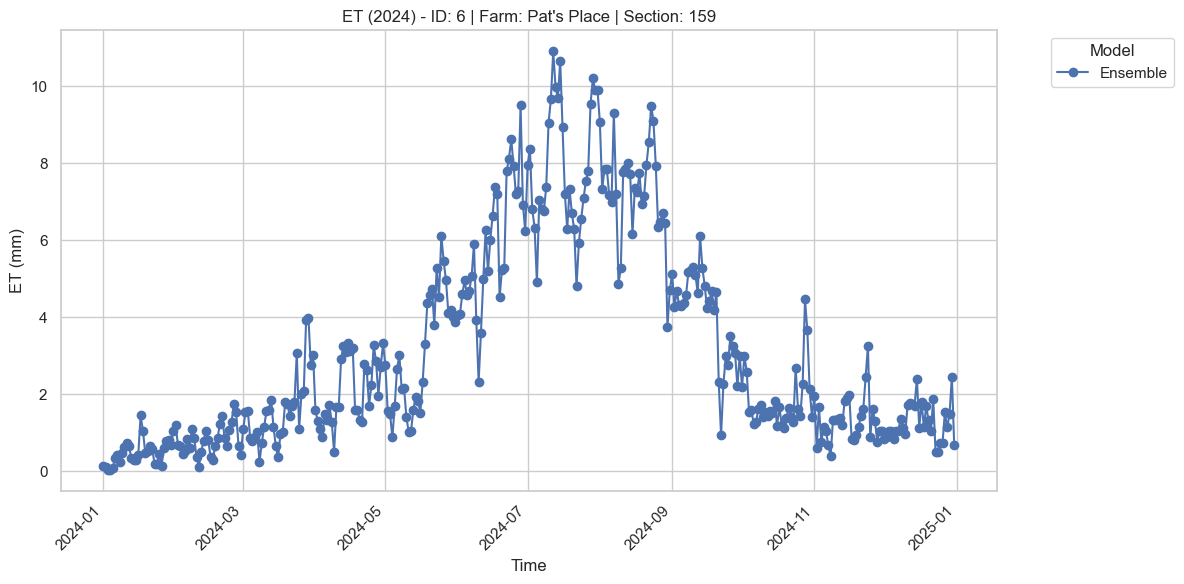

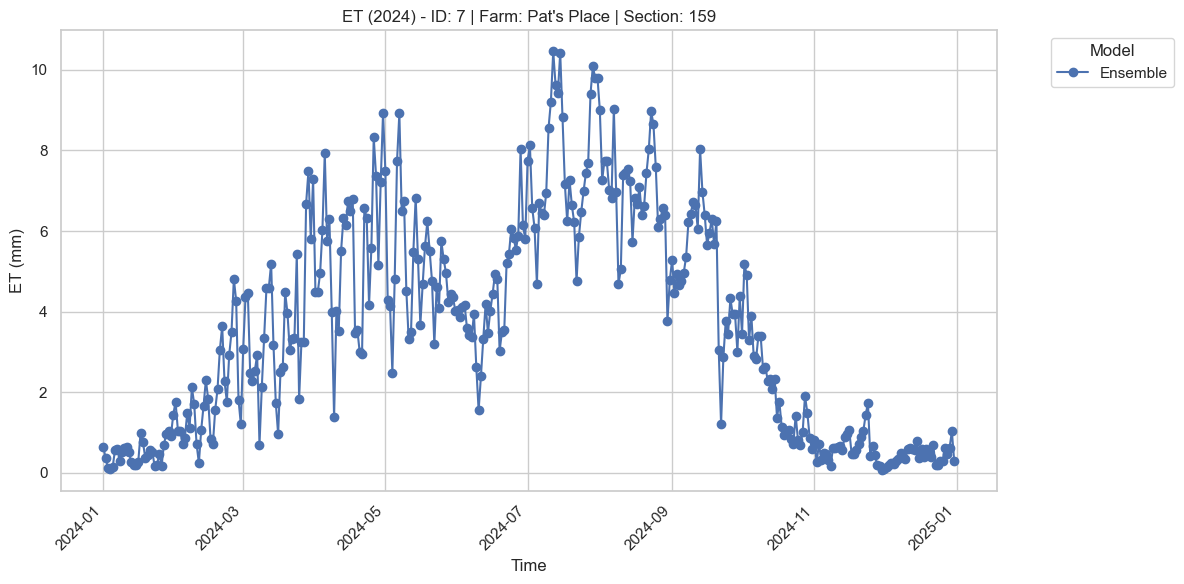

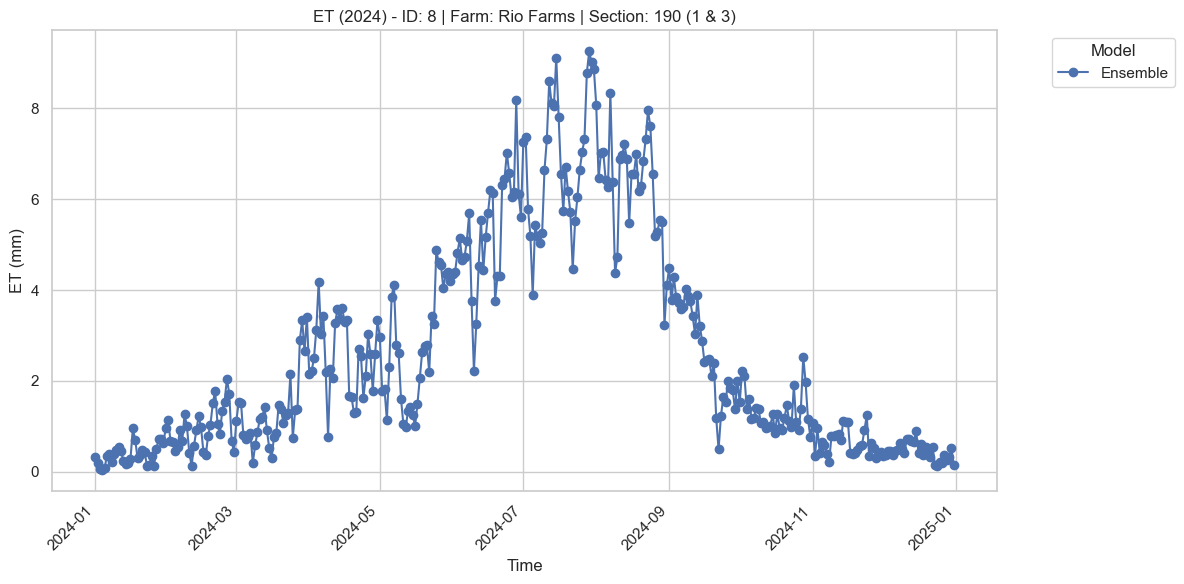

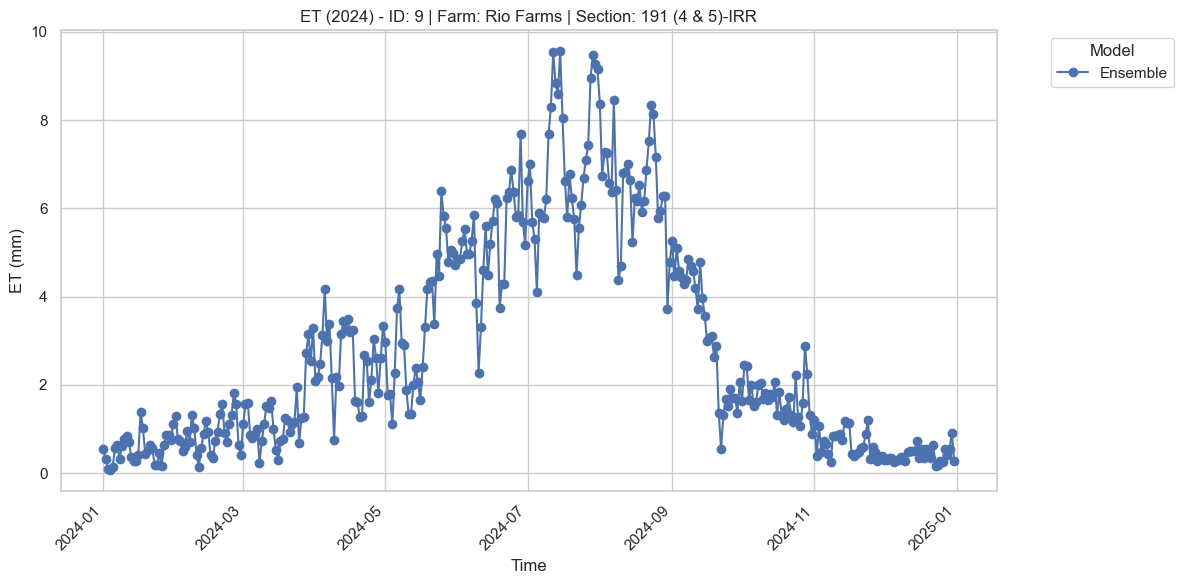

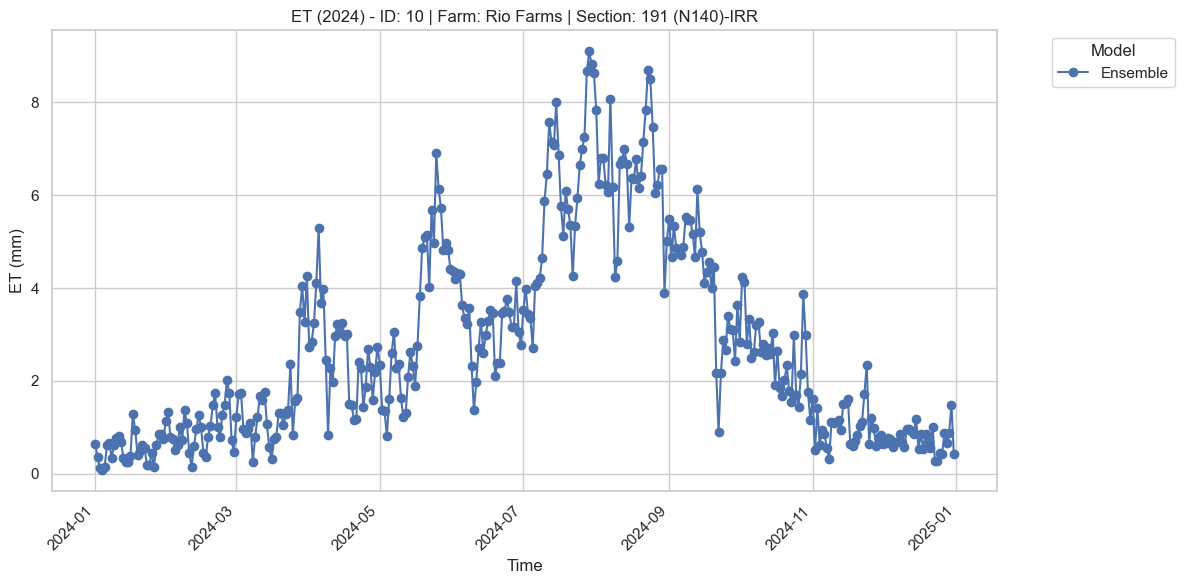

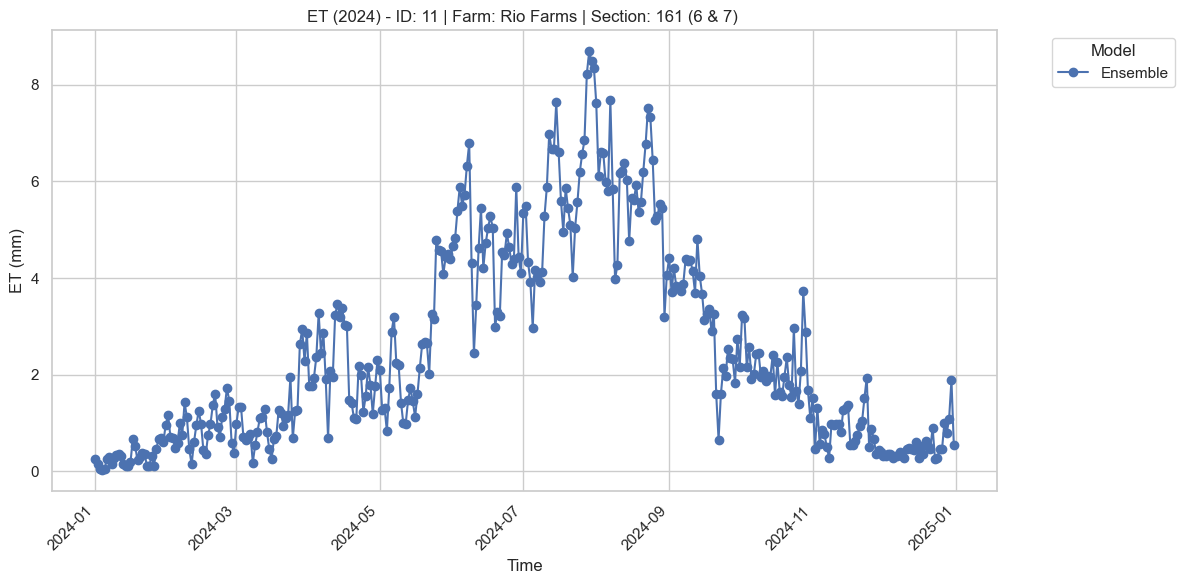

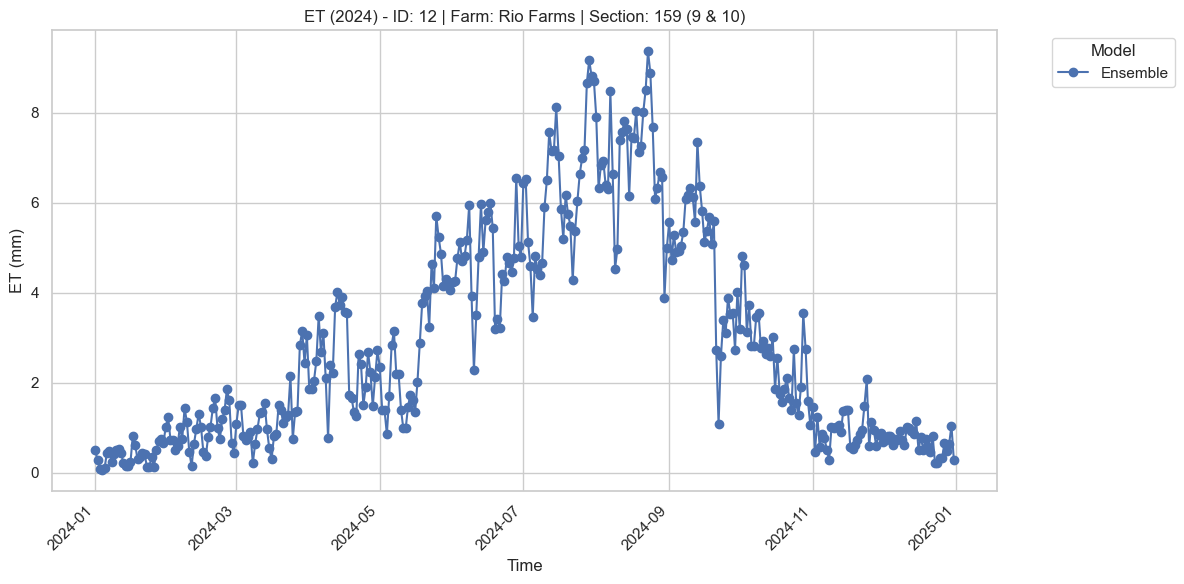

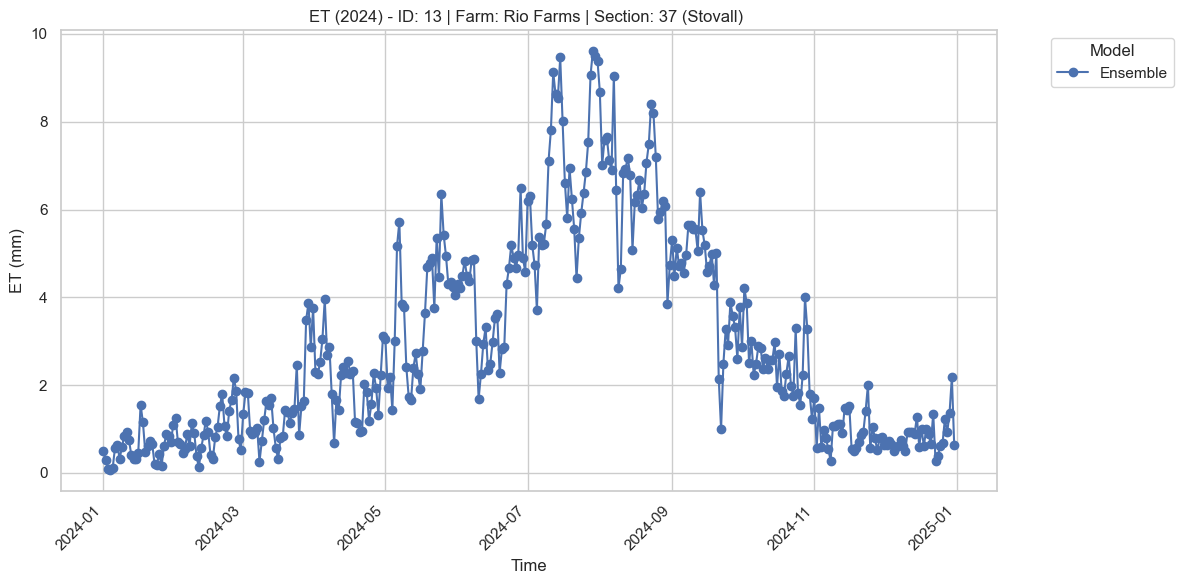

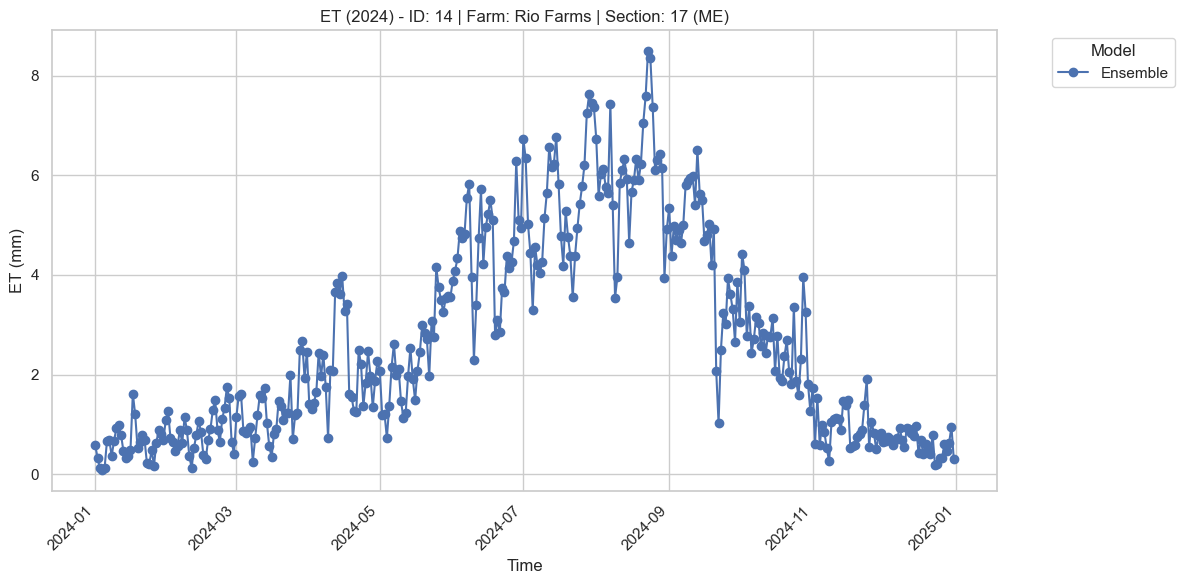

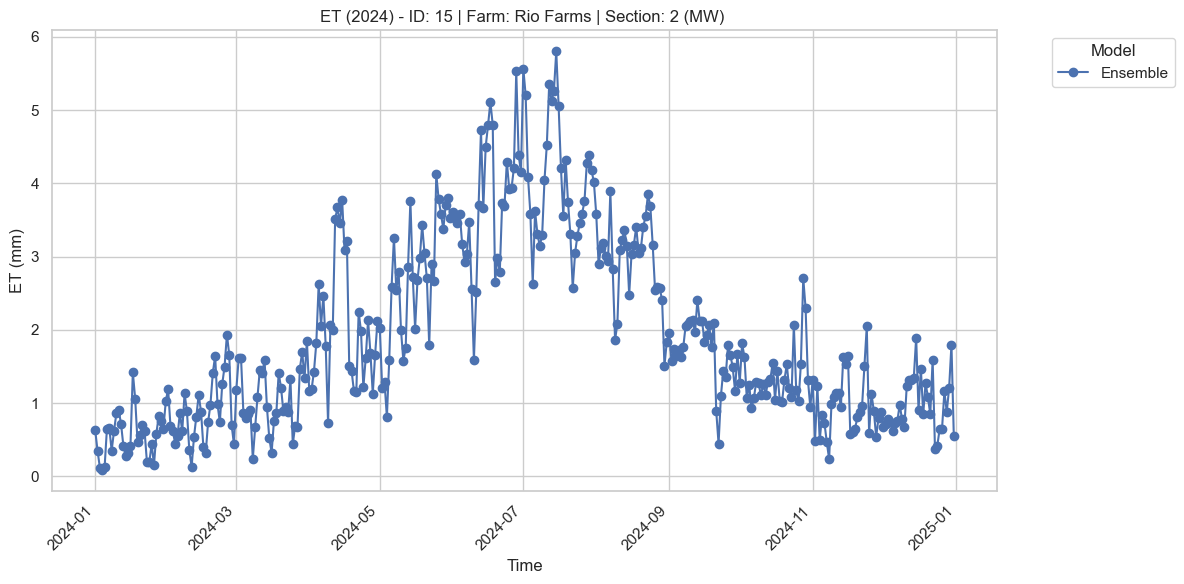

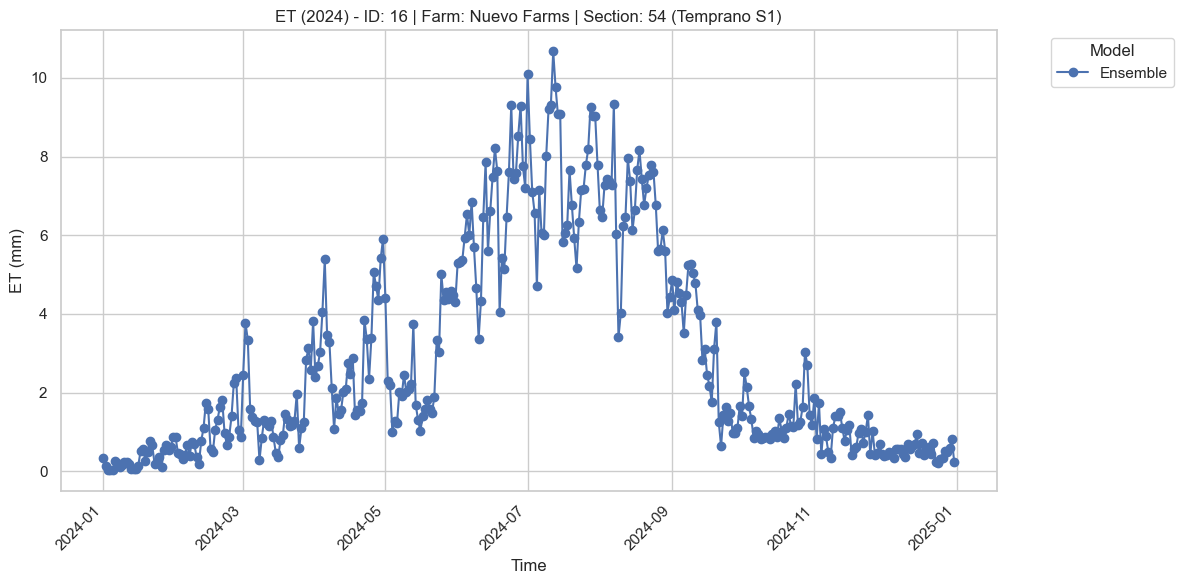

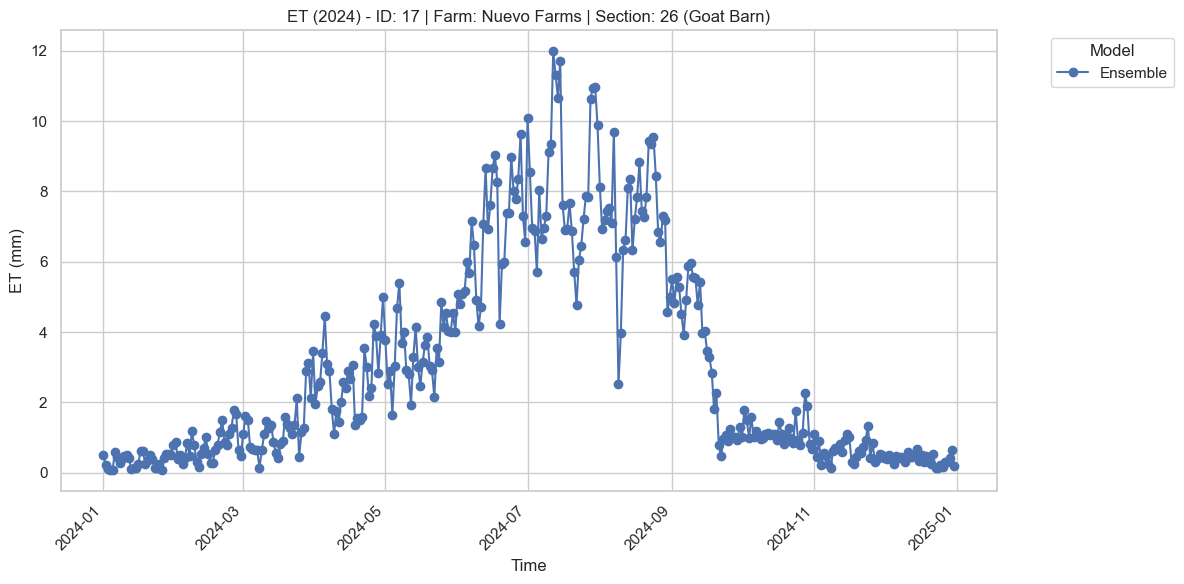

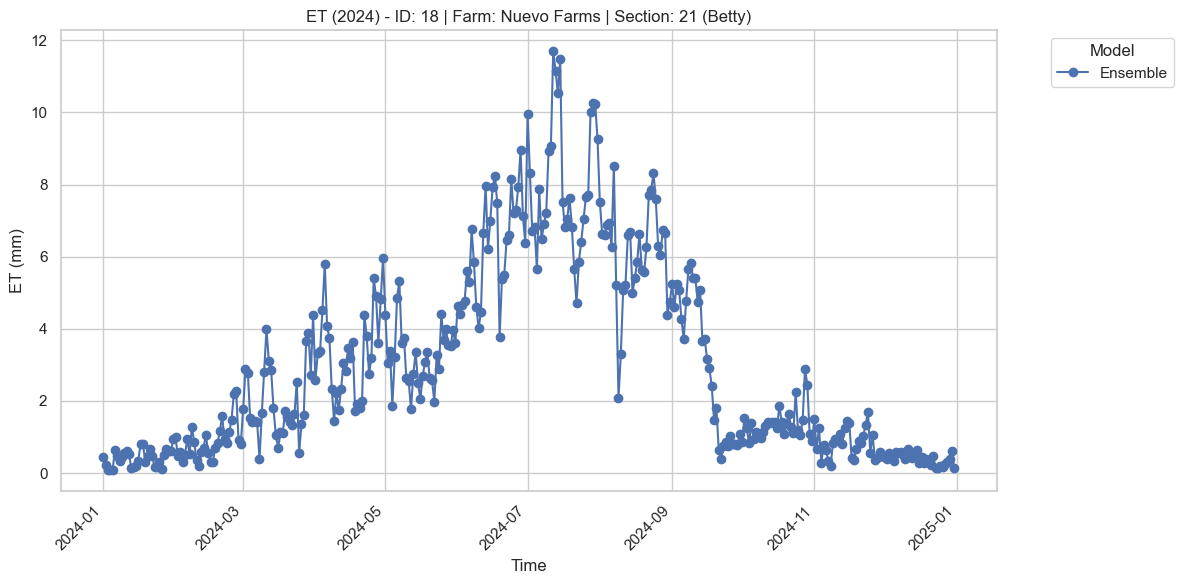

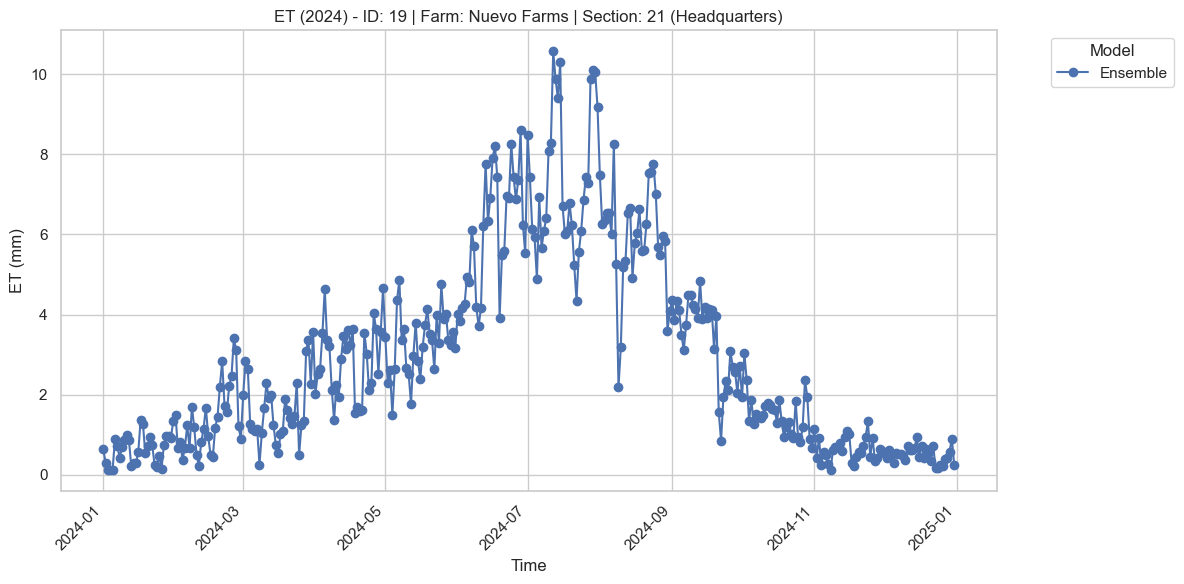

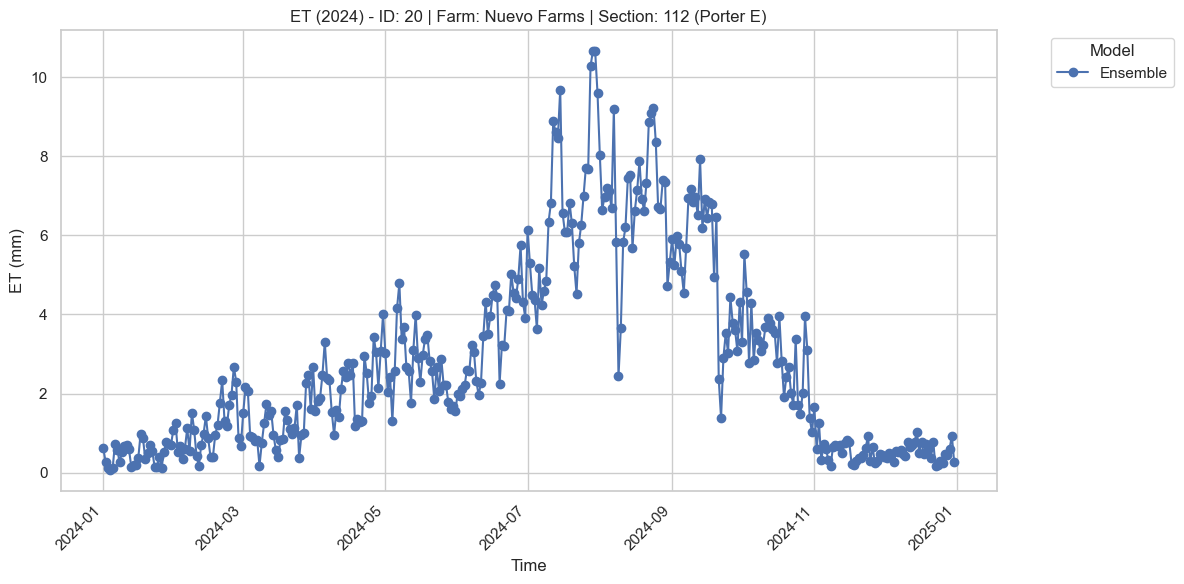

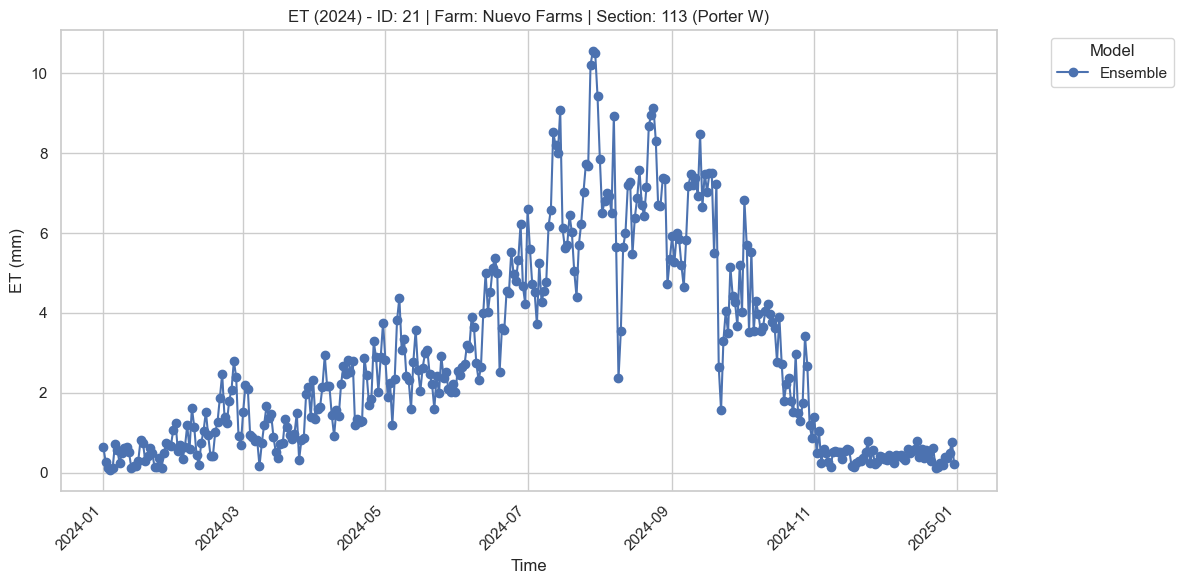

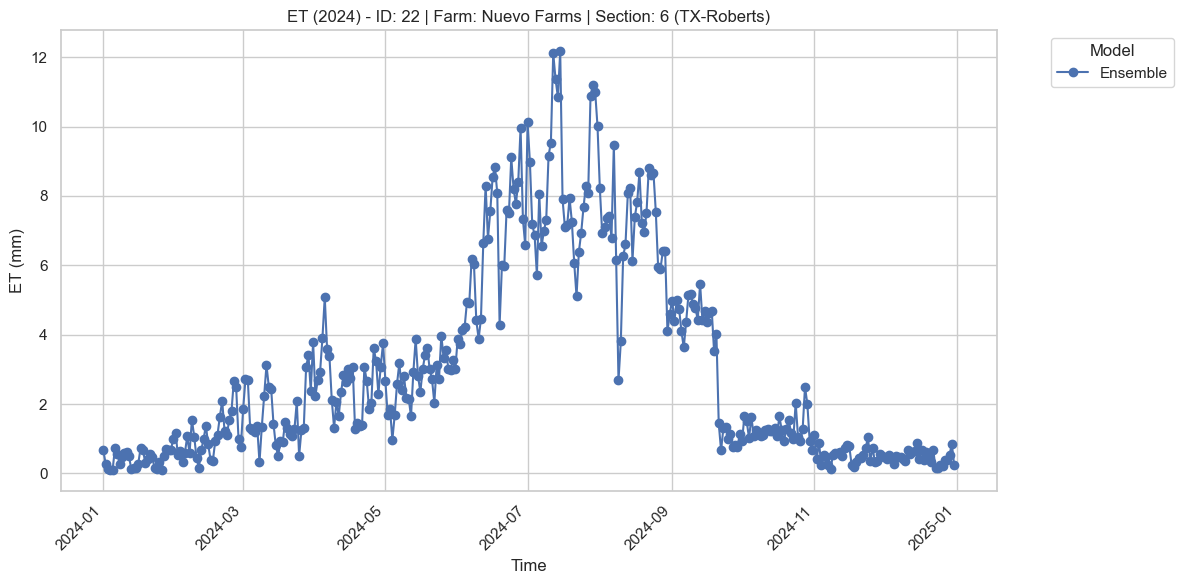

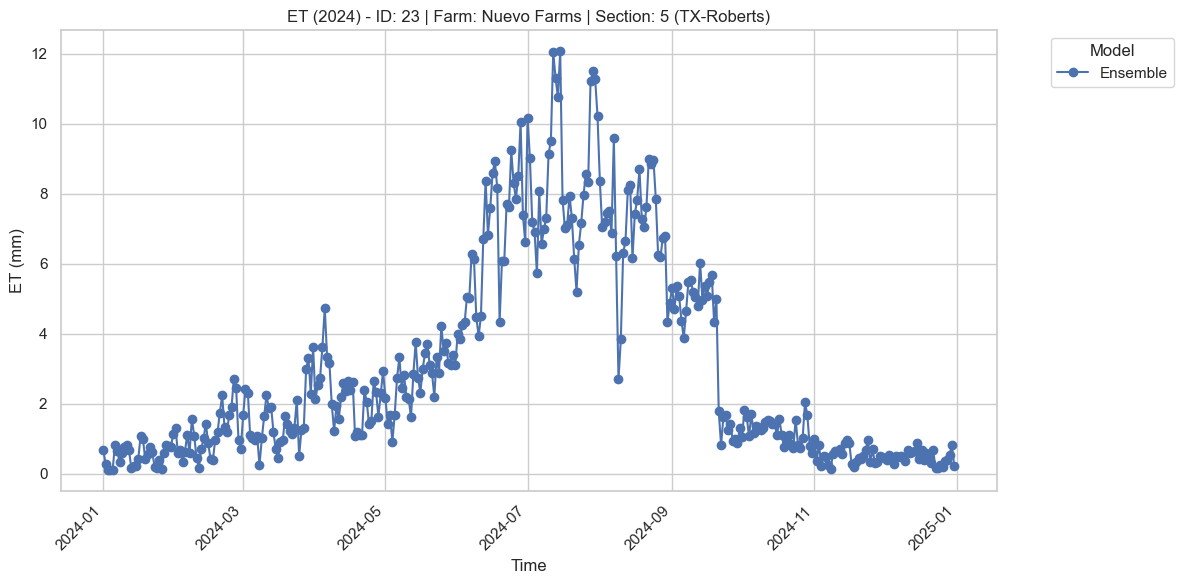

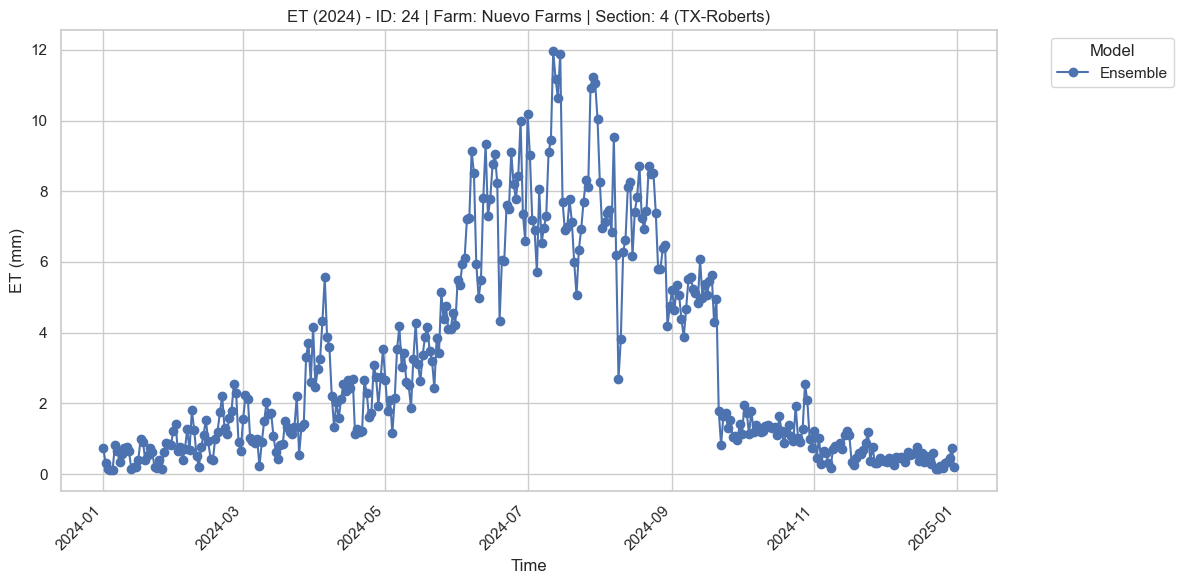

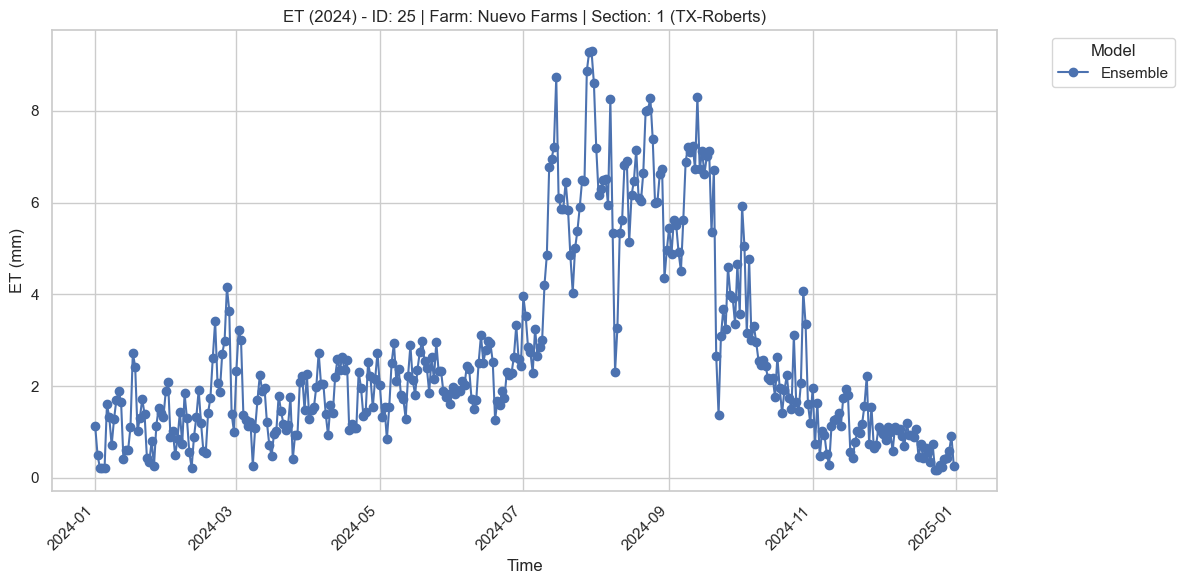

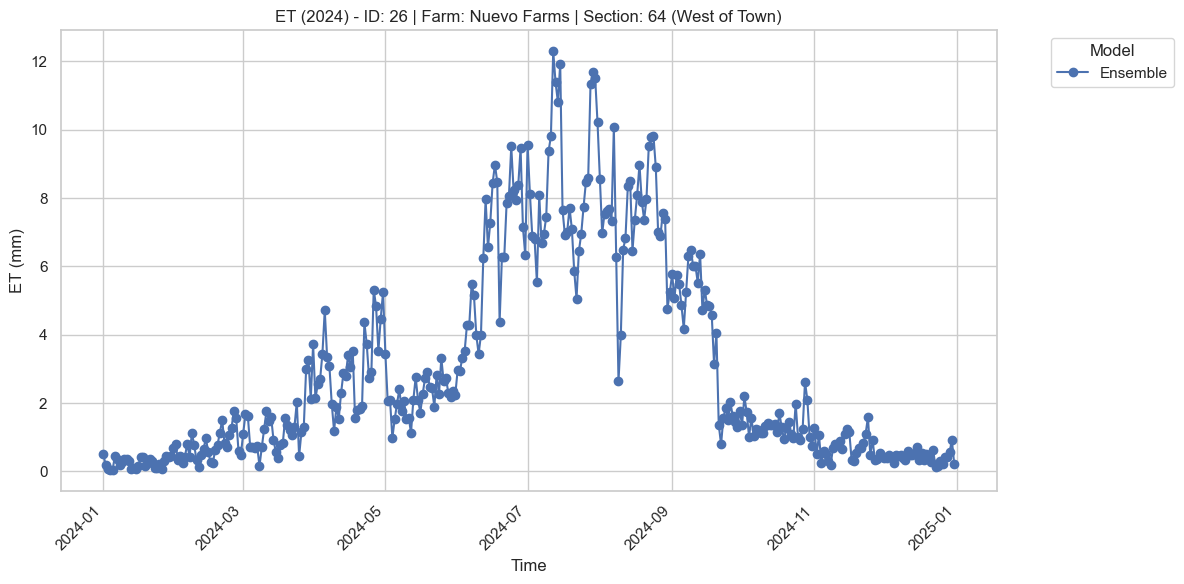

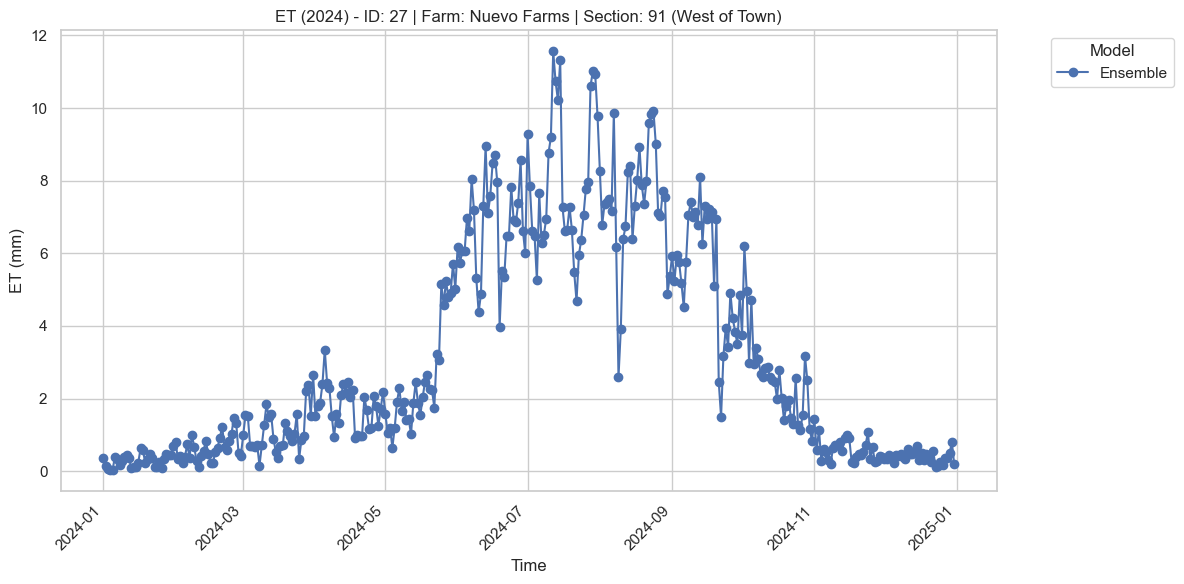

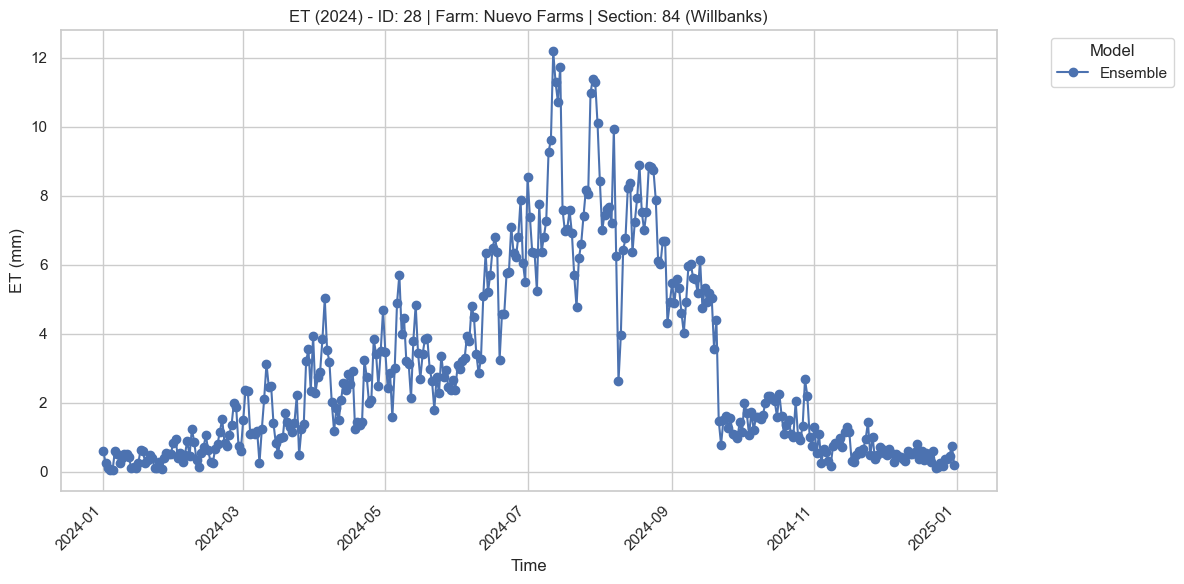

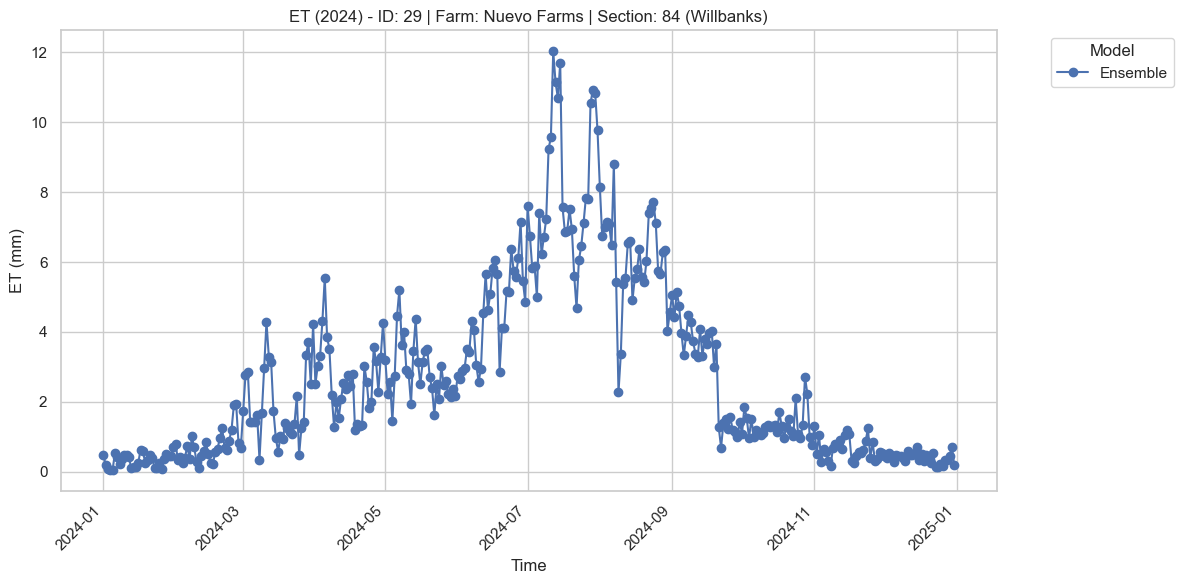

In [71]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined JSON file
with open("openet_all_locations_2024.json", "r") as f:
    all_data = json.load(f)

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6)})

# Loop through each record (each location x variable)
for record in all_data:
    id_number = record['id_number']
    farm = record['farm']
    section = record['section']
    variable = record['variable']
    year = record['year']
    et_data = record['et_data']

    # Skip if no ET data
    if not et_data:
        continue

    # Build DataFrame from all models
    df_all = pd.DataFrame()

    for model, values in et_data.items():
        if not values:
            continue
        df_temp = pd.DataFrame(values)
        df_temp['time'] = pd.to_datetime(df_temp['time'])
        df_temp.set_index('time', inplace=True)
        df_temp = df_temp.rename(columns={'et': model})
        df_all = pd.concat([df_all, df_temp[model]], axis=1)

    if df_all.empty:
        continue

    df_all = df_all.sort_index()

    # Plot
    ax = df_all.plot(marker='o')
    plt.title(f"{variable} ({year}) - ID: {id_number} | Farm: {farm} | Section: {section}")
    plt.xlabel("Time")
    plt.ylabel(f"{variable} (mm)")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [72]:
import json
import pandas as pd

# Load JSON file (list of records)
with open("openet_all_locations_2024.json", "r") as f:
    data = json.load(f)

# Container for all rows
all_rows = []

# Loop through each record
for record in data:
    meta = {
        "id_number": str(record["id_number"]),
        "farm": str(record["farm"]),
        "section": str(record["section"]),
        "year": int(record["year"]),
        "latitude": float(record["latitude"]),
        "longitude": float(record["longitude"]),
        "variable": record["variable"]
    }

    # Build model-wise data frame
    et_frames = []
    for model, values in record["et_data"].items():
        if values:  # skip if empty
            df_model = pd.DataFrame(values)
            df_model["time"] = pd.to_datetime(df_model["time"])
            df_model.set_index("time", inplace=True)
            df_model.rename(columns={"et": model}, inplace=True)
            et_frames.append(df_model)

    if et_frames:
        df_merged = pd.concat(et_frames, axis=1).reset_index()
        for key, val in meta.items():
            df_merged[key] = val
        all_rows.append(df_merged)

# Combine all into one DataFrame
final_df = pd.concat(all_rows, ignore_index=True)

# Reorder columns
meta_cols = ["id_number", "farm", "section", "year", "latitude", "longitude", "variable", "time"]
model_cols = [col for col in final_df.columns if col not in meta_cols]
final_df = final_df[meta_cols + model_cols]

# Show result
print(final_df.head())


  id_number     farm section  year  latitude  longitude variable       time  \
0         1  Margoso     288  2024  35.88795 -102.13271       ET 2024-01-01   
1         1  Margoso     288  2024  35.88795 -102.13271       ET 2024-01-02   
2         1  Margoso     288  2024  35.88795 -102.13271       ET 2024-01-03   
3         1  Margoso     288  2024  35.88795 -102.13271       ET 2024-01-04   
4         1  Margoso     288  2024  35.88795 -102.13271       ET 2024-01-05   

   Ensemble  
0     0.512  
1     0.165  
2     0.084  
3     0.085  
4     0.087  


In [73]:
final_df.to_excel('ET_2024.xlsx')